In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

$$ k(x_{i}, x_{j}) = \sigma^{2}_{f}exp(-\frac{1}{2l^2}(x_i - x_j)^T(x_i - x_j))$$

In [33]:
def gaussian_kernel(x_i, x_j, l, s):
    '''
    Compute gaussian kernel
    
    Inputs:
        - X: numpy array (m * p)
        - X: numpy array (n * p)
        - l: smoothness parameter
        - s: sigma parameter
    '''
    # (a - b)^2 = a^2 - 2ab + b^2
    sq_dist = np.sum(x_i**2, 1).reshape(-1, 1) + np.sum(x_j**2, 1) - 2 * np.dot(x_i, x_j.T)
    kernel = s ** 2 * np.exp(-0.5 / l ** 2 * sq_dist)
    
    return kernel

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)



In [36]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)
# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = gaussian_kernel(X, X, 1, 1)

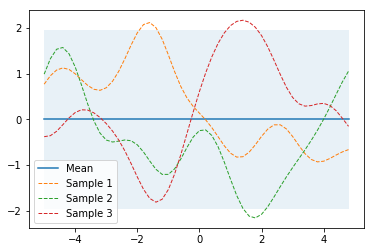

In [38]:
# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)
# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

In [43]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''  
    Computes the sufficient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = gaussian_kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = gaussian_kernel(X_train, X_s, l, sigma_f)
    K_ss = gaussian_kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s


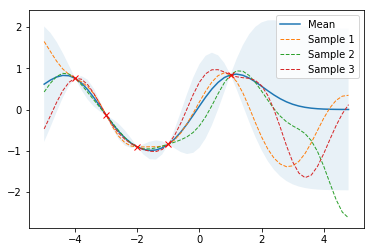

In [44]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
